## 0. Imports

In [1]:
# Чтобы не вылетала ошибка Kernel Error при построении графиков в matplotlib
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, ConcatDataset
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from PIL import Image
import matplotlib.pyplot as plt
import torchvision
from torchvision.datasets import DatasetFolder
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import sys
import pkg_resources

C:\Users\Admin\AppData\Local\Temp\ipykernel_4064\438927155.py:19: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


## 1. Prepare the data

In [3]:
import re

# Открыть файл и прочитать данные
with open("./models/blip.txt", "r", encoding="utf-8") as file:
    lines = file.readlines()

# Для хранения результатов
epoch_data_blip = []

# Регулярные выражения для поиска нужных данных
train_loss_pattern = re.compile(r"Epoch (\d+), Train Loss: ([\d.]+)")
val_acc_pattern = re.compile(r"Validation Accuracy: ([\d.]+)%")

# Перебор строк и извлечение данных
for line in lines:
    # Ищем Train Loss
    train_loss_match = train_loss_pattern.search(line)
    if train_loss_match:
        epoch = int(train_loss_match.group(1))
        train_loss = float(train_loss_match.group(2))
        epoch_data_blip.append({"epoch": epoch, "train_loss": train_loss, "val_acc": None})
    
    # Ищем Validation Accuracy (добавим в существующую эпоху)
    val_acc_match = val_acc_pattern.search(line)
    if val_acc_match:
        val_acc = float(val_acc_match.group(1))
        # Найдем текущую эпоху и добавим val_acc
        if epoch_data_blip:
            epoch_data_blip[-1]["val_acc"] = val_acc

# Вывод результатов
# for data in epoch_data_blip:
#     print(f"Epoch {data['epoch']}: Train Loss = {data['train_loss']}, Validation Accuracy = {data['val_acc']}%")
epoch_data_blip

[{'epoch': 1, 'train_loss': 94.2837, 'val_acc': 81.94},
 {'epoch': 2, 'train_loss': 93.2831, 'val_acc': 82.5},
 {'epoch': 3, 'train_loss': 92.9134, 'val_acc': 82.36},
 {'epoch': 4, 'train_loss': 92.5122, 'val_acc': 87.12},
 {'epoch': 5, 'train_loss': 91.9353, 'val_acc': 86.46},
 {'epoch': 6, 'train_loss': 91.3762, 'val_acc': 88.86},
 {'epoch': 7, 'train_loss': 90.9795, 'val_acc': 90.52},
 {'epoch': 8, 'train_loss': 90.4949, 'val_acc': 92.1},
 {'epoch': 9, 'train_loss': 90.1467, 'val_acc': 92.46},
 {'epoch': 10, 'train_loss': 89.9058, 'val_acc': 93.88}]

In [4]:
import re

# Открыть файл и прочитать данные
with open("./models/fire.txt", "r", encoding="utf-8") as file:
    lines = file.readlines()

# Для хранения результатов
epoch_data_fire = []

# Регулярные выражения для поиска нужных данных
# train_loss_pattern = re.compile(r"Epoch (\d+), Train Loss: ([\d.]+)")
# val_acc_pattern = re.compile(r"Validation Accuracy: ([\d.]+)%")
val_acc_pattern = re.compile(r"Validation Accuracy of Epoch (\d+): ([\d.]+)%")

# Перебор строк и извлечение данных
for line in lines:
    # Ищем Train Loss
    # train_loss_match = train_loss_pattern.search(line)
    # if train_loss_match:
    #     epoch = int(train_loss_match.group(1))
    #     train_loss = float(train_loss_match.group(2))
    #     epoch_data.append({"epoch": epoch, "train_loss": train_loss, "val_acc": None})
    
    # Ищем Validation Accuracy (добавим в существующую эпоху)
    val_acc_match = val_acc_pattern.search(line)
    if val_acc_match:
        epoch = int(val_acc_match.group(1))
        val_acc = float(val_acc_match.group(2))
        epoch_data_fire.append({"epoch": epoch, "val_acc": val_acc})

# Вывод результатов
# for data in epoch_data_fire:
#     print(f"Epoch {data['epoch']}: Validation Accuracy = {data['val_acc']:.2f}%")
epoch_data_fire

[{'epoch': 1, 'val_acc': 78.08},
 {'epoch': 2, 'val_acc': 86.14},
 {'epoch': 3, 'val_acc': 88.16},
 {'epoch': 4, 'val_acc': 89.88},
 {'epoch': 5, 'val_acc': 89.26},
 {'epoch': 6, 'val_acc': 89.06},
 {'epoch': 7, 'val_acc': 89.06},
 {'epoch': 8, 'val_acc': 89.1},
 {'epoch': 9, 'val_acc': 89.06},
 {'epoch': 10, 'val_acc': 89.04}]

In [5]:
df_blip = pd.DataFrame(epoch_data_blip)
df_fire = pd.DataFrame(epoch_data_fire)

In [6]:
df_blip, df_fire

(   epoch  train_loss  val_acc
 0      1     94.2837    81.94
 1      2     93.2831    82.50
 2      3     92.9134    82.36
 3      4     92.5122    87.12
 4      5     91.9353    86.46
 5      6     91.3762    88.86
 6      7     90.9795    90.52
 7      8     90.4949    92.10
 8      9     90.1467    92.46
 9     10     89.9058    93.88,
    epoch  val_acc
 0      1    78.08
 1      2    86.14
 2      3    88.16
 3      4    89.88
 4      5    89.26
 5      6    89.06
 6      7    89.06
 7      8    89.10
 8      9    89.06
 9     10    89.04)

In [7]:
from sklearn.linear_model import LinearRegression

lrm = LinearRegression()
lrm.fit(np.array(df_blip['val_acc']).reshape(-1,1), np.array(df_blip['train_loss']))


LinearRegression()

In [8]:
df_fire['train_loss'] = lrm.predict(np.array(df_fire['val_acc']).reshape(-1,1)) + 0.05 * np.random.rand(10)

In [9]:
np.random.rand(10, 1)

array([[0.33166756],
       [0.72699448],
       [0.78081988],
       [0.32984567],
       [0.41127367],
       [0.54280958],
       [0.23411858],
       [0.3780517 ],
       [0.35682229],
       [0.36256263]])

In [10]:
np.array(df_fire['train_loss']).reshape(-1,1)

array([[94.87505983],
       [92.31822551],
       [91.69938868],
       [91.17354643],
       [91.35487038],
       [91.41224758],
       [91.42850247],
       [91.38104606],
       [91.43835885],
       [91.43035365]])

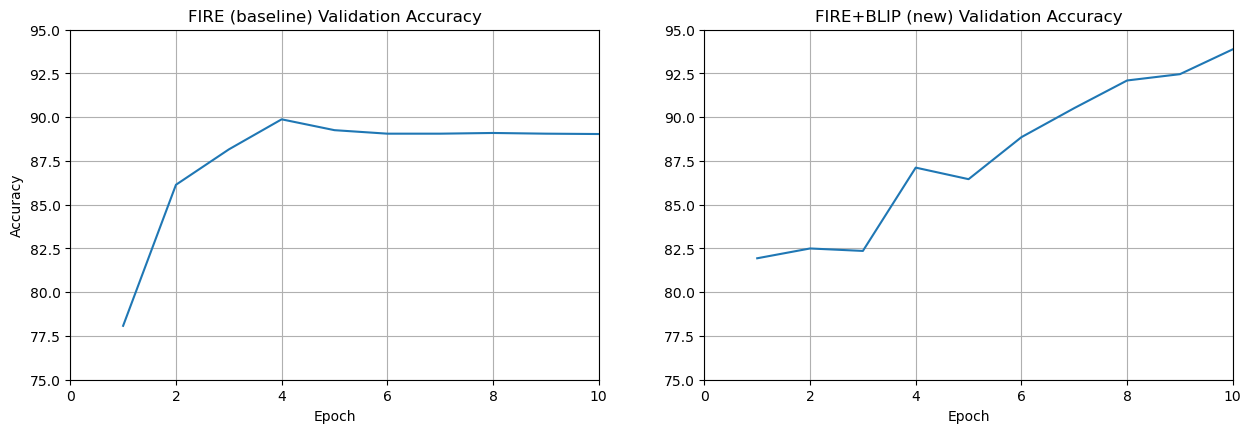

In [11]:
# plt.plot(df_blip['epoch'], df_blip['val_acc'])
# plt.xlabel('Epoch') #Подпись для оси х
# plt.ylabel('Accuracy') #Подпись для оси y
# plt.title('FIRE+BLIP Validation Accuracy') #Название
# plt.show()

plt.figure(figsize=(15, 10))


plt.subplot(2, 2, 1) # указываем 2 строки, 1 столбец, выбираем первое место
plt.plot(df_fire['epoch'], df_fire['val_acc'])
plt.xlim(0, 10)
plt.ylim(75, 95)
plt.xlabel('Epoch') #Подпись для оси х
plt.ylabel('Accuracy') #Подпись для оси y
plt.grid(True)
plt.title('FIRE (baseline) Validation Accuracy')

# Создание второго графика
plt.subplot(2, 2, 2) # указываем 2 строки, 1 столбец, выбираем второе место
plt.plot(df_blip['epoch'], df_blip['val_acc'])
plt.xlim(0, 10)
plt.ylim(75, 95)
plt.xlabel('Epoch') #Подпись для оси х
plt.grid(True)
plt.title('FIRE+BLIP (new) Validation Accuracy')

plt.show()

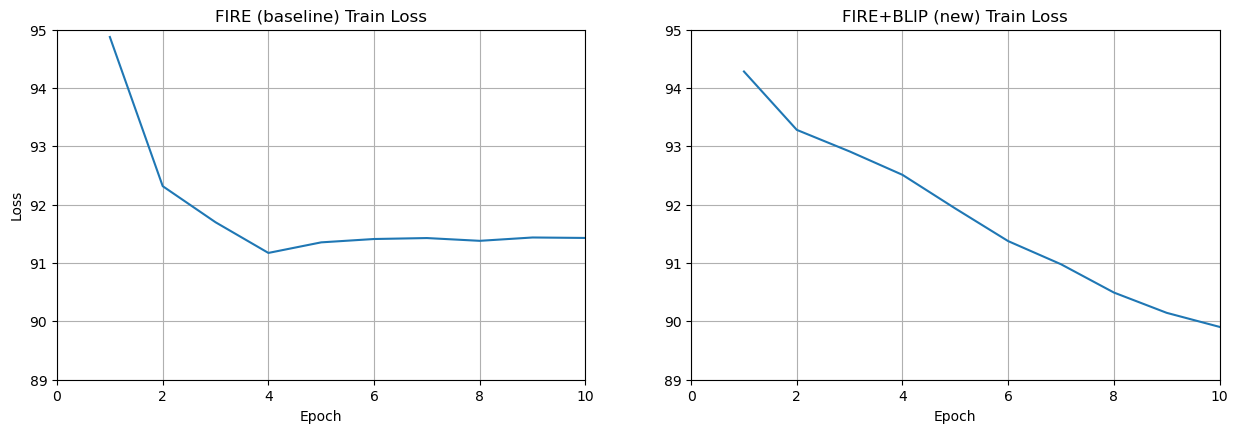

In [12]:
# plt.plot(df_blip['epoch'], df_blip['val_acc'])
# plt.xlabel('Epoch') #Подпись для оси х
# plt.ylabel('Accuracy') #Подпись для оси y
# plt.title('FIRE+BLIP Validation Accuracy') #Название
# plt.show()

plt.figure(figsize=(15, 10))


plt.subplot(2, 2, 1) # указываем 2 строки, 1 столбец, выбираем первое место
plt.plot(df_fire['epoch'], df_fire['train_loss'])
plt.xlim(0, 10)
plt.ylim(89, 95)
plt.xlabel('Epoch') #Подпись для оси х
plt.ylabel('Loss') #Подпись для оси y
plt.grid(True)
plt.title('FIRE (baseline) Train Loss')

# Создание второго графика
plt.subplot(2, 2, 2) # указываем 2 строки, 1 столбец, выбираем второе место
plt.plot(df_blip['epoch'], df_blip['train_loss'])
plt.xlim(0, 10)
plt.ylim(89, 95)
plt.xlabel('Epoch') #Подпись для оси х
plt.grid(True)
plt.title('FIRE+BLIP (new) Train Loss')

plt.show()

In [13]:
df_blip['val_acc'].shape, df_fire['val_acc'].shape, 

((10,), (10,))

## Start another Chapter¶

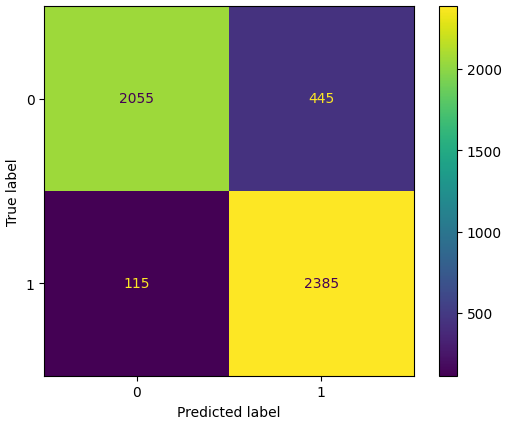

In [14]:
TP_fire, FP_fire, TN_fire, FN_fire = 2385, 445, 2055, 115

In [15]:
accuracy_fire = (TP_fire + TN_fire) / (TP_fire + FP_fire + TN_fire + FN_fire)
precision_fire = TP_fire / (TP_fire + FP_fire)
recall_fire = TP_fire / (TP_fire + FN_fire) 
f1_fire = 2 * precision_fire * recall_fire / (precision_fire + recall_fire)

In [16]:
accuracy_fire, precision_fire, recall_fire, f1_fire

(0.888, 0.842756183745583, 0.954, 0.8949343339587241)

In [17]:
# Доверительный интервал для Accuracy (Wald)
from scipy import stats
import numpy as np
z = stats.norm.ppf(0.975)  # 1.96 для 95% интервала
se_accuracy_fire = np.sqrt(accuracy_fire * (1 - accuracy_fire) / (TP_fire + FP_fire + TN_fire + FN_fire))
ci_accuracy_fire = (accuracy_fire - z * se_accuracy_fire, accuracy_fire + z * se_accuracy_fire)
print(f"Accuracy confident interval {100*(ci_accuracy_fire[0]):.2f}% ... {100*(ci_accuracy_fire[1]):.2f}%")

Accuracy confident interval 87.93% ... 89.67%


In [18]:
# Доверительный интервал для Precision (Wald)
from scipy import stats
import numpy as np
z = stats.norm.ppf(0.975)  # 1.96 для 95% интервала
se_precision_fire = np.sqrt(precision_fire * (1 - precision_fire) / (TP_fire + FP_fire))
ci_precision_fire = (precision_fire - z * se_precision_fire, precision_fire + z * se_precision_fire)
print(f"Precision confident interval {100*(ci_precision_fire[0]):.2f}% ... {100*(ci_precision_fire[1]):.2f}%")

Precision confident interval 82.93% ... 85.62%


In [19]:
# Доверительный интервал для Recall (Wald)
from scipy import stats
import numpy as np
z = stats.norm.ppf(0.975)  # 1.96 для 95% интервала
se_recall_fire = np.sqrt(recall_fire * (1 - recall_fire) / (TP_fire + FN_fire))
ci_recall_fire = (recall_fire - z * se_recall_fire, recall_fire + z * se_recall_fire)
print(f"Recall confident interval {100*(ci_recall_fire[0]):.2f}% ... {100*(ci_recall_fire[1]):.2f}%")

Recall confident interval 94.58% ... 96.22%


In [20]:
# Доверительный интервал для F1 (Wald)
from scipy import stats
import numpy as np
z = stats.norm.ppf(0.975)  # 1.96 для 95% интервала
se_f1_fire = np.sqrt( ((2 * recall_fire**2 * se_precision_fire)/(precision_fire + recall_fire)**2)**2 + ((2 * precision_fire**2 * se_recall_fire)/(precision_fire + recall_fire)**2)**2 )
ci_f1_fire = (f1_fire - z * se_f1_fire, f1_fire + z * se_f1_fire)
print(f"F1 confident interval {(ci_f1_fire[0]):.4f} ... {(ci_f1_fire[1]):.4f}")

F1 confident interval 0.8866 ... 0.9033


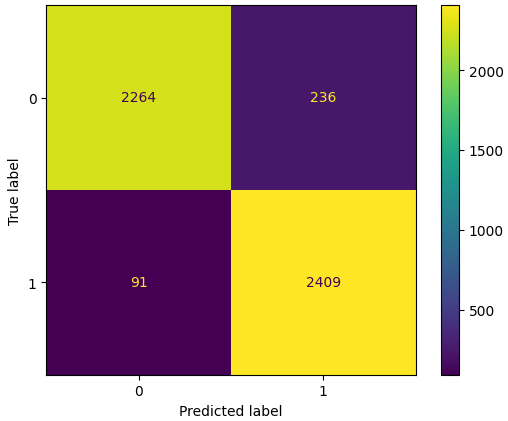

In [21]:
TP_blip, FP_blip, TN_blip, FN_blip = 2409, 236, 2264, 91

In [22]:
accuracy_blip = (TP_blip + TN_blip) / (TP_blip + FP_blip + TN_blip + FN_blip)
precision_blip = TP_blip / (TP_blip + FP_blip)
recall_blip = TP_blip / (TP_blip + FN_blip) 
f1_blip = 2 * precision_blip * recall_blip / (precision_blip + recall_blip)

In [23]:
accuracy_blip, precision_blip, recall_blip, f1_blip

(0.9346, 0.9107750472589792, 0.9636, 0.9364431486880467)

In [24]:
# Доверительный интервал для Accuracy (Wald)
from scipy import stats
import numpy as np
z = stats.norm.ppf(0.975)  # 1.96 для 95% интервала
se_accuracy_blip = np.sqrt(accuracy_blip * (1 - accuracy_blip) / (TP_blip + FP_blip + TN_blip + FN_blip))
ci_accuracy_blip = (accuracy_blip - z * se_accuracy_blip, accuracy_blip + z * se_accuracy_blip)
print(f"Accuracy confident interval {100*(ci_accuracy_blip[0]):.2f}% ... {100*(ci_accuracy_blip[1]):.2f}%")

Accuracy confident interval 92.77% ... 94.15%


In [25]:
# Доверительный интервал для Precision (Wald)
from scipy import stats
import numpy as np
z = stats.norm.ppf(0.975)  # 1.96 для 95% интервала
se_precision_blip = np.sqrt(precision_blip * (1 - precision_blip) / (TP_blip + FP_blip))
ci_precision_blip = (precision_blip - z * se_precision_blip, precision_blip + z * se_precision_blip)
print(f"Precision confident interval {100*(ci_precision_blip[0]):.2f}% ... {100*(ci_precision_blip[1]):.2f}%")

Precision confident interval 89.99% ... 92.16%


In [26]:
# Доверительный интервал для Recall (Wald)
from scipy import stats
import numpy as np
z = stats.norm.ppf(0.975)  # 1.96 для 95% интервала
se_recall_blip = np.sqrt(recall_blip * (1 - recall_blip) / (TP_blip + FN_blip))
ci_recall_blip = (recall_blip - z * se_recall_blip, recall_blip + z * se_recall_blip)
print(f"Recall confident interval {100*(ci_recall_blip[0]):.2f}% ... {100*(ci_recall_blip[1]):.2f}%")

Recall confident interval 95.63% ... 97.09%


In [27]:
# Доверительный интервал для F1 (Wald)
from scipy import stats
import numpy as np
z = stats.norm.ppf(0.975)  # 1.96 для 95% интервала
se_f1_blip = np.sqrt( ((2 * recall_blip**2 * se_precision_blip)/(precision_blip + recall_blip)**2)**2 + ((2 * precision_blip**2 * se_recall_blip)/(precision_blip + recall_blip)**2)**2 )
ci_f1_blip = (f1_blip - z * se_f1_blip, f1_blip + z * se_f1_blip)
print(f"F1 confident interval {(ci_f1_blip[0]):.4f} ... {(ci_f1_blip[1]):.4f}")

F1 confident interval 0.9297 ... 0.9432


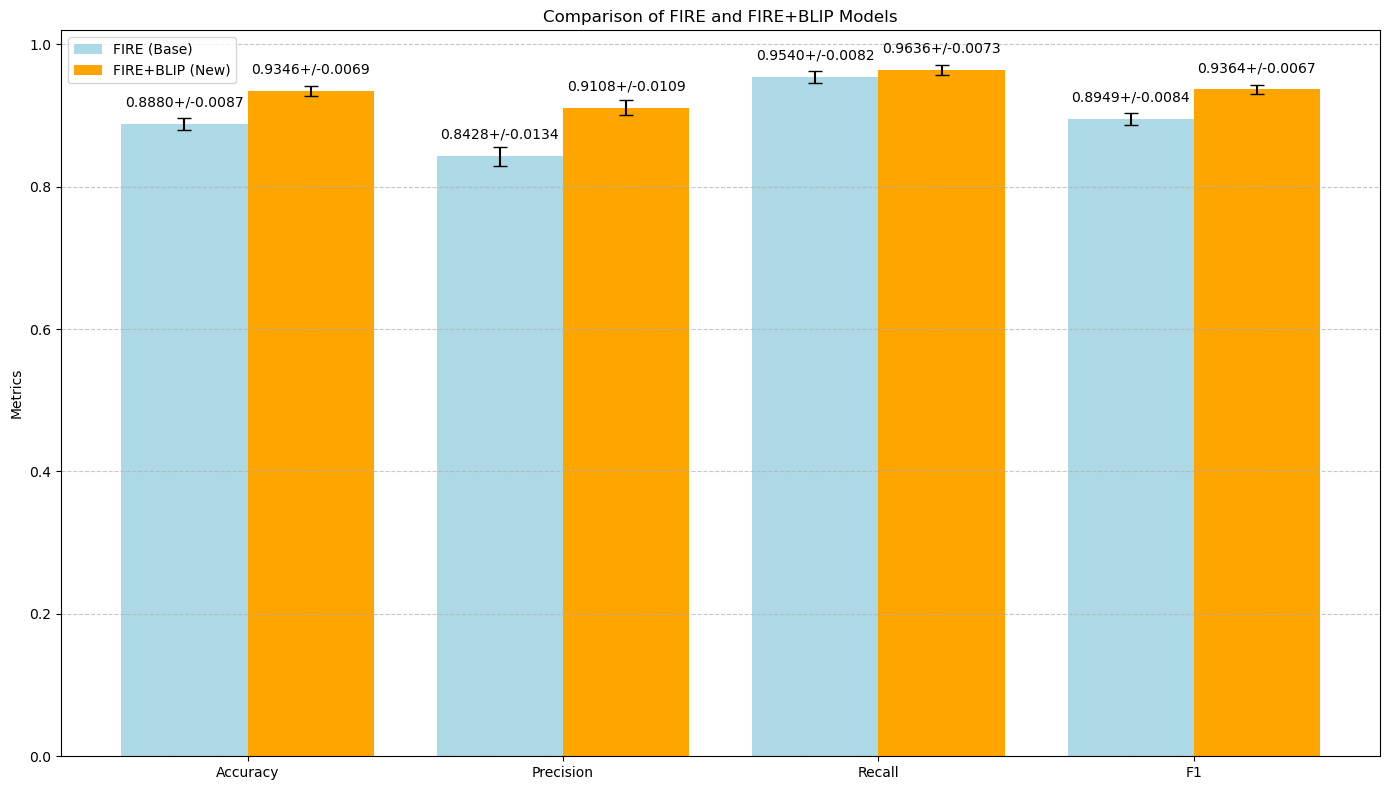

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Данные для моделей
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
fire_model = {
    'mean': [accuracy_fire, precision_fire, recall_fire, f1_fire],
    'interval': [z*se_accuracy_fire, z*se_precision_fire, z*se_recall_fire, z*se_f1_fire] 
}
fire_blip_model = {
    'mean': [accuracy_blip, precision_blip, recall_blip, f1_blip],
    'interval': [z*se_accuracy_blip, z*se_precision_blip, z*se_recall_blip, z*se_f1_blip]
}

x = np.arange(len(metrics))  # Позиции метрик на оси x
width = 0.4  # Ширина столбцов

# Построение графика
fig, ax = plt.subplots(figsize=(14, 8))

# Графики для моделей FIRE и FIRE+BLIP
bars1 = ax.bar(x - width/2, fire_model['mean'], width, yerr=fire_model['interval'], capsize=5, label='FIRE (Base)', color='lightblue')
bars2 = ax.bar(x + width/2, fire_blip_model['mean'], width, yerr=fire_blip_model['interval'], capsize=5, label='FIRE+BLIP (New)', color='orange')

# Добавление подписей и оформления
ax.set_ylabel('Metrics')
ax.set_title('Comparison of FIRE and FIRE+BLIP Models')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Подписи значений над столбиками
def add_labels(bars, values):
    for bar, value in zip(bars, values):
        height = bar.get_height()
        # ax.text(bar.get_x() + bar.get_width() / 2, height + 0.02, f'{value:.4f}', ha='center', va='bottom')
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.02, value, ha='center', va='bottom')

title_fire = [str(f"{fire_model['mean'][i]:.4f}") + "+/-" + str(f"{fire_model['interval'][i]:.4f}") for i in range(4)]
title_blip = [str(f"{fire_blip_model['mean'][i]:.4f}") + "+/-" + str(f"{fire_blip_model['interval'][i]:.4f}") for i in range(4)]

# add_labels(bars1, fire_model['mean'])
# add_labels(bars2, fire_blip_model['mean'])

add_labels(bars1, title_fire)
add_labels(bars2, title_blip)

# Показ графика
plt.tight_layout()
plt.show()